In [1]:
#aggregate spaghetti plots of the target for 
#non-business and business users over the 24 hours of all days

In [60]:
import pandas as pd
from common import data_folder_path
import matplotlib.pyplot as plt
import os

In [61]:
data_file = 'train.csv'
df = pd.read_csv(os.path.join(data_folder_path,data_file))

In [62]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime']

0         2021-09-01 00:00:00
1         2021-09-01 00:00:00
2         2021-09-01 00:00:00
3         2021-09-01 00:00:00
4         2021-09-01 00:00:00
                  ...        
2018347   2023-05-31 23:00:00
2018348   2023-05-31 23:00:00
2018349   2023-05-31 23:00:00
2018350   2023-05-31 23:00:00
2018351   2023-05-31 23:00:00
Name: datetime, Length: 2018352, dtype: datetime64[ns]

In [63]:
df['Time of Day']=df['datetime'].dt.hour

In [75]:
def get_dist_df(df,z=1.96, is_consumer=0,is_business=0,clip = True):
    if is_consumer is None:
        if is_business is None:
            mean_df = pd.DataFrame(df.groupby(['Time of Day'])['target'].mean())
            std_df = pd.DataFrame(df.groupby(['Time of Day'])['target'].std())
        else:
            mean_df = pd.DataFrame(df[(df['is_business']==is_business)].groupby(['Time of Day'])['target'].mean())
            std_df = pd.DataFrame(df[(df['is_business']==is_business)].groupby(['Time of Day'])['target'].std())
    else:
        if is_business is None:
            mean_df = pd.DataFrame(df[(df['is_consumption']==is_consumer)].groupby(['Time of Day'])['target'].mean())
            std_df = pd.DataFrame(df[(df['is_consumption']==is_consumer)].groupby(['Time of Day'])['target'].std())
        else:
            mean_df = pd.DataFrame(df[(df['is_consumption']==is_consumer)&(df['is_business']==is_business)].groupby(['Time of Day'])['target'].mean())
            std_df = pd.DataFrame(df[(df['is_consumption']==is_consumer)&(df['is_business']==is_business)].groupby(['Time of Day'])['target'].std())


    pivot_mean_df = pd.pivot_table(mean_df.reset_index(),values='target',index='Time of Day')
    pivot_std_df = pd.pivot_table(std_df.reset_index(),values='target',index='Time of Day')
    pivot_dist_df = pivot_mean_df.copy()
    sample_size = pd.DataFrame(df.groupby(['Time of Day']).size()).rename(columns={0:'target'})

    pivot_dist_df['lower_range'] = pivot_mean_df - z*pivot_std_df/(sample_size**0.5)
    pivot_dist_df['upper_range'] = pivot_mean_df + z*pivot_std_df/(sample_size**0.5)

    if clip:
        pivot_dist_df=pivot_dist_df.clip(0)

    return pivot_dist_df

In [76]:
distribution_dfs = {}
for is_consumer in [0,1]:
    distribution_dfs[is_consumer] = {}
    for is_business in [0,1]:
        pivot_dist_df = get_dist_df(df,z=1.96, is_consumer=is_consumer,is_business=is_business,clip = True)
        pivot_dist_df.to_csv(os.path.join(data_folder_path,'pivot_dist_df_{}_{}.csv'.format(is_consumer,is_business)))
        distribution_dfs[is_consumer][is_business] = pivot_dist_df

In [77]:
def plot_distribution(pivot_dist_df,ax,title,ylabel='Target'):
    ax.plot(pivot_dist_df.index,pivot_dist_df['target'],label='mean')
    ax.fill_between(pivot_dist_df.index,pivot_dist_df['lower_range'],pivot_dist_df['upper_range'],alpha=0.3,label='95% CI')
    ax.set_title(title)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel(ylabel)
    ax.legend()

In [78]:
def get_distribution_plot_title(is_consumer,is_business):
    if is_consumer==0:
        is_consumer = 'Producer'
    else:
        is_consumer = 'Consumer'
    if is_business==0:
        is_business = 'Non-Business'
    else:
        is_business = 'Business'
    return '{} {}'.format(is_consumer,is_business)

def get_distribution_plot_ylabel(is_consumer):
    ylabel = 'Energy'
    if is_consumer==0:
        return ylabel+' Production'
    else:
        return ylabel+' Consumption'
    
def plot_distributions(distribution_dfs):
    fig,ax = plt.subplots(2,2,figsize=(15,15))
    for i,is_consumer in enumerate([0,1]):
        for j,is_business in enumerate([0,1]):
            plot_distribution(distribution_dfs[is_consumer][is_business],ax[i][j],
                title=get_distribution_plot_title(is_consumer,is_business),
                ylabel=get_distribution_plot_ylabel(is_consumer))
    plt.show()

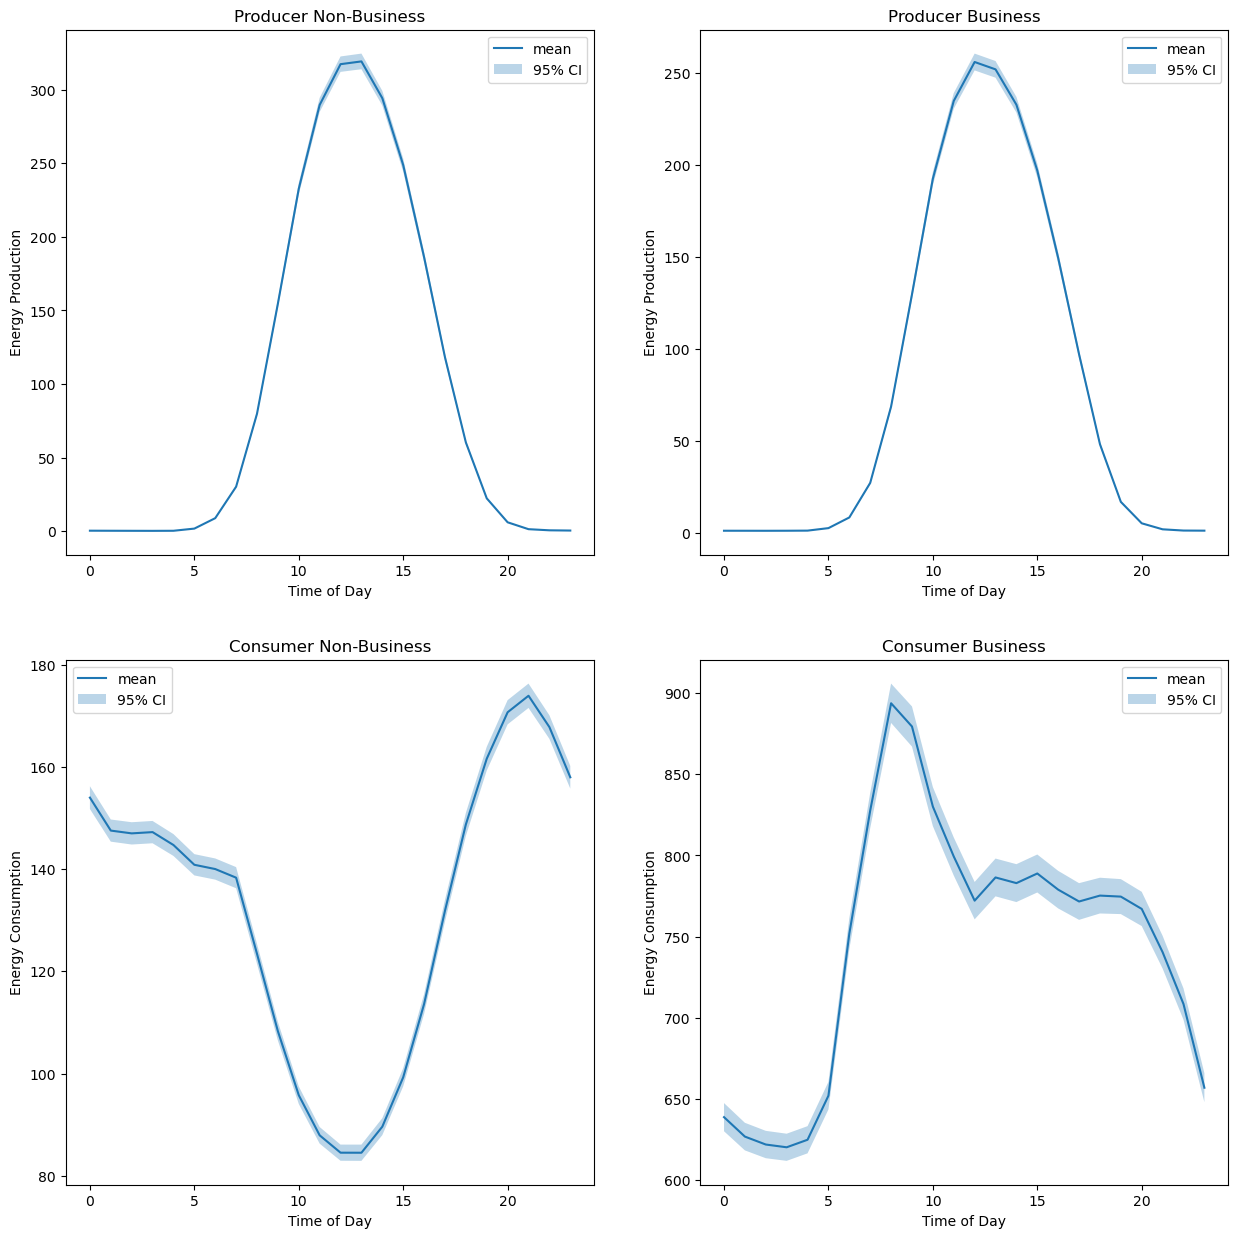

In [79]:
plot_distributions(distribution_dfs)

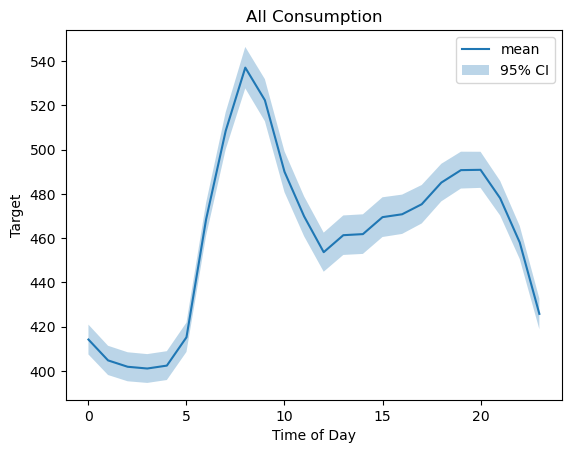

In [80]:
plot_distribution(get_dist_df(df,z=1.96, is_consumer=1,is_business=None,clip = True),ax=plt.gca(),title='All Consumption')

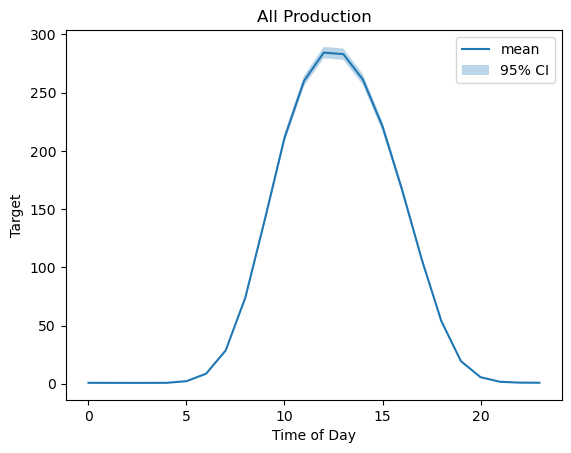

In [82]:
plot_distribution(get_dist_df(df,z=1.96, is_consumer=0,is_business=None,clip = True),ax=plt.gca(),title='All Production')

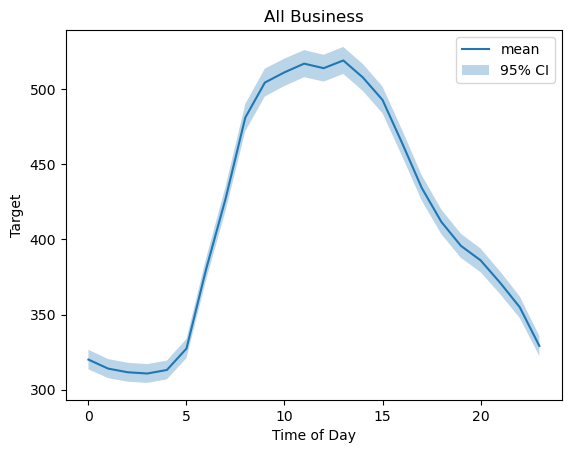

In [83]:
plot_distribution(get_dist_df(df,z=1.96, is_consumer=None,is_business=1,clip = True),ax=plt.gca(),title='All Business')

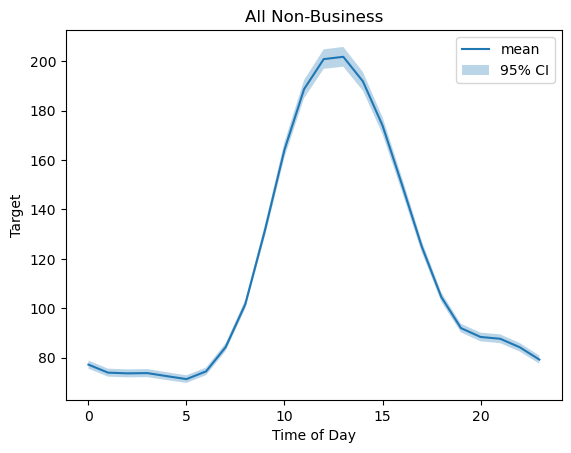

In [84]:
plot_distribution(get_dist_df(df,z=1.96, is_consumer=None,is_business=0,clip = True),ax=plt.gca(),title='All Non-Business')